![logo](JFM-notebooks-logo.jpg)

# Fitting the SSM-reduced model

In this notebook we use the training data located in the folder ```data/``` to obtain an SSM-reduced model. The data was generated by ```Openpipeflow```, developed by Ashley Willis (see https://openpipeflow.org/).

We use the ```SSMLearn``` library to obtain a parametrization of the two-dimensional mixed-mode SSM connecting the lower branch traveling wave with the laminar state. The restriction of the dynamics onto this SSM then yields a two dimensional SSM-reduced model.

- We load several trajectories, each of which contains a time series of the energy input ($I$) and energy dissipation ($D$) values, as computed by Openpipeflow. We also load the time dependent velocity fields $\mathbf{u}(r, \varphi, z, t)$ in a compressed format. Instead of every Fourier-coefficient returned by Openpipeflow we have only retain the leading 100 PCA-components of the full dataset.
- We then determine the optimal polynomial order and the regularizing parameter $\alpha$ via cross validation. 
- We visualize the two-dimensional SSM-reduced model as a vector field and explicitly calculate the stable manifold of the lower branch traveling wave. Since the edge of chaos intersects the mixed-mode SSM transversely, we can conclude that this intersection is formed as the stable manifold of the lower branch traveling wave in the SSM-reduced model.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [3]:
def transform(x):
    return np.sqrt(1+x)-1
def untransform(x):
    return (x+1)**2-1

## Load the data from the pre-compiled dictionary

This file contains 

- Reduced coordinates of the trajectories (as computed by Openpipeflow)
- Compressed version of the velocity fields. The compression is the projection onto the first 100 PCA modes


In [4]:
training_data = np.load('data/Re2400_train.npy', allow_pickle=True).item()


In [5]:
n_trajs = 8
reduced_state = []
full_state = []
for i in range(n_trajs):
    reduced_state.append(training_data['reduced_state_%s' %i][:])
    full_state.append(training_data['full_state_%s' %i][:])
    

In [6]:
time_array = []

In [7]:
for i in range(n_trajs):
    time = np.arange(0, reduced_state[i].shape[1], 1)*0.1
    time_array.append(time)

In [8]:
from ssmlearnpy import SSMLearn

INFO   2023-05-30 20:25:17 utils NumExpr defaulting to 4 threads.


In [9]:
from ssmlearnpy.reduced_dynamics.advector import advect


We initialize an ```SSMLearn``` object from the training trajectories.

In [10]:
ssm = SSMLearn(
    t = time_array, 
    x = full_state, 
    reduced_coordinates = reduced_state,
    ssm_dim=2, 
    dynamics_type = 'flow'
)

Fit the reduced dynamics in the form 

$$
\frac{d}{dt}\begin{pmatrix}J  \\ K \end{pmatrix} = \mathbf{f}(J,K)= \sum_{n+m\leq M_r} \begin{pmatrix} R^{(J)}_{nm} K^m J^n \\ R^{(K)}_{nm} K^m J^n\end{pmatrix}
$$


We enforce that the lower branch traveling wave remains a fixed point of the reduced dynamics. Its coordinates are 
$$
J = 0.101187 \; K = 0.1011201.
$$

In [11]:
lb_jk_coords = [0.101187, 0.1011201]

To determine the coefficients $R^{(J,K)}_{nm}$, we minimize the cost function

$$
L = \sum_{i}\left[ \left(\dot{J} - \sum_{n,m} R^{(J)}_{nm}K^mJ^n\right)^2 +\left(\dot{K} - \sum_{n,m} R^{(K)}_{nm}K^mJ^n\right)^2 + \alpha \sum_{n,m}\left((R^{(J)}_{nm})^2 + (R^{(K)}_{nm})^2 \right)\right],
$$

where $\alpha$ is a ridge-type regularizing term. 

The parametrization, i.e. the mapping $\mathbf{W}$ 

with

$$
\mathbf{u}(t) = \mathbf{W}(J(t), K(t))
$$

is also determined via ridge regression.

## Determining the optimal model order by cross validation

The maximal polynomial order for the regression $M_r$ and the parameter $\alpha$ can be determined by cross validating against a trajectory that was withheld from the training set. 

Given the true trajectory $\mathbf{u}_{true}$, we define the prediction error as

$$
    \text{Error} = \sum_i \left \Vert \mathbf{u}_{true}(t_i) - \mathbf{W} \circ F^{t_i}(J_{true}(0), K_{true}(0))\right \Vert,
$$

i.e. the averaged error between the image of the predicted reduced trajectory under the parametrization $\mathbf{W}$ and the true trajectory. 

In [13]:
def crossval(degree, alpha, true_reduced_state, true_full_state, indexStart):
    # fit the two mappings:
    ssm.get_reduced_dynamics(poly_degree = degree, alpha = alpha, constraints=[[lb_jk_coords],[[0.,0.]]]) 
    ssm.get_parametrization(poly_degree = degree, alpha = alpha, do_scaling = False)
    # helper functions for solve_ivp
    predictor = lambda x: ssm.reduced_dynamics.predict(x)
    def tocallfunDynamics(t, x, dyn):
        dy = dyn(np.array(x).reshape(1,-1))
        return np.squeeze(np.array(dy))
    # prediction 
    ic = true_reduced_state[:,indexStart]
    teval = np.arange(indexStart, true_reduced_state.shape[1], 1)*0.1
    
    tspan = [teval[0],
        teval[-1]]
    
    sol = solve_ivp(tocallfunDynamics, 
                    tspan, ic, 
                    t_eval = teval,
                    method = 'DOP853',
                    rtol = 1e-6,
                    atol = 1e-6,
                    args=(predictor, ))
    if not sol.success:
        return np.nan
    
    validation_pred = ssm.decoder.predict(sol.y.T).T 
    err = true_full_state[:, indexStart:] - validation_pred
    errnorm = np.linalg.norm(err, axis = 0)
    
    return np.mean(errnorm)


In [14]:
import logging

# disable logging in the cross validation loop
logging.disable(logging.CRITICAL)


In [15]:
orders = np.arange(2, 10, 1)
alphas = np.logspace(-12, -1, 20)

In [16]:
indexStart = 150


In [17]:
# suppress ill-conditioned warnings. 
# we select the best model by cross-validation anyways
import warnings
warnings.filterwarnings('ignore')


In [18]:
errors = []
for o in orders:
    errors_for_alpha = []
    for a in alphas:
        errors_for_alpha.append(crossval(o, a,  
             transform(training_data['validation_parameters']),
             training_data['validation_full_state'], indexStart))
    errors.append(errors_for_alpha)


After calculating the erorrs, we can visualize them over a grid of $\alpha$ values and polynomial orders.

In [19]:
errors = np.array(errors)
O, A = np.meshgrid(orders, alphas)

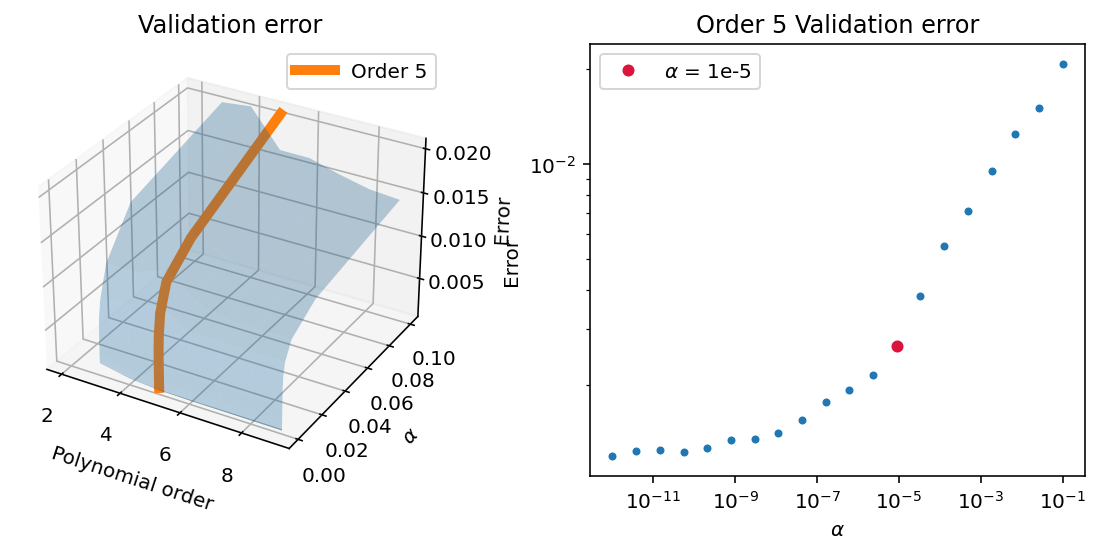

In [25]:
%matplotlib inline 
f = plt.figure(figsize = (8, 4))
ax = f.add_subplot(121,projection = '3d')
ax2 = f.add_subplot(122)
ax.plot_surface(O,A, errors.T, alpha = 0.3)
ax.set_title('Validation error')
ax.set_xlabel('Polynomial order')
ax.set_ylabel(r'$\alpha$')
ax.set_zlabel('Error')
ax.plot(alphas*0 + 5, alphas, errors[2,:], '-', linewidth = 5, label = 'Order 5')
ax2.loglog(alphas, errors[2, :], '.', )
ax2.set_title('Order 5 Validation error')
ax2.set_xlabel(r'$\alpha$')
ax2.set_ylabel('Error')
ax2.plot(alphas[-8], errors[2, -8], '.', markersize = 10, c='Crimson', label = r'$\alpha$ = 1e-5')
ax.legend()
ax2.legend()
f.tight_layout()

Based on the $\alpha-$dependence of the validation error, we may select $\alpha$=1e-5, which is a relatively high value, allowing strong regularization. 

## Predictions of the optimal SSM-reduced model

First fit the parametrization and then the reduced dynamics.

In [27]:
ssm.get_parametrization(poly_degree = 5, alpha = 1e-5)

In [28]:
ssm.get_reduced_dynamics(poly_degree=5, alpha =1e-5, constraints=[[lb_jk_coords],[[0.,0.]]])

We can check that the constraint is satisfied

In [29]:
ssm.reduced_dynamics.predict(np.array(lb_jk_coords).reshape(1,-1))

array([[ 2.92799639e-14, -9.85154666e-13]])

### Visualizing the prediction error along the validation trajectory

In [30]:
def tocallfunDynamics(t, x, dyn):
    
    dy = dyn(np.array(x).reshape(1,-1))
    return np.squeeze(np.array(dy))

In [31]:
predictor = lambda x: ssm.reduced_dynamics.predict(x)


In [32]:
from scipy.integrate import solve_ivp

### Visualizing the validation-prediction

This is the trajectory we have used to select $\alpha$ and the polynomial order. We now compute the SSM-perdicted trajectory, by integrating its initial reduced-coordinates forward in time. 

In [34]:
ic = transform(training_data['validation_parameters'][:,indexStart]) # need to take the square root

In [37]:
dt = 0.1 # openpipeflow saves the I-D coordinates 10 times in each integer time instant
teval = np.arange(indexStart, training_data['validation_parameters'].shape[1], 1)*dt
tspan = [teval[0],
        teval[-1]]

In [38]:

sol = solve_ivp(tocallfunDynamics, 
                tspan, ic, 
                t_eval = teval,
                method = 'DOP853',
                rtol = 1e-6,
                atol = 1e-12,
                args=(predictor, ))

validation_pred = ssm.decoder.predict(sol.y.T).T


We now plot the time evolution of the predicted reduced coordinate and the time-dependent relative prediction error

In [40]:
# maximal value of the norm of the true velocity field
tonorm = np.linalg.norm(training_data['validation_full_state'], axis = 0).max()

In [41]:
err = training_data['validation_full_state'][:, indexStart:] - validation_pred

Text(0.5, 1.0, 'Validation trajectory')

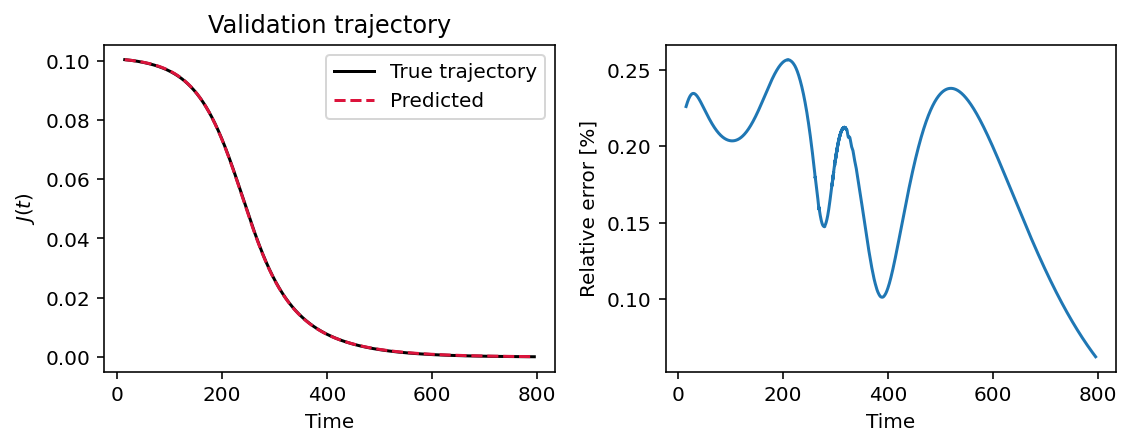

In [42]:
f = plt.figure(figsize = (8, 3))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax.plot(teval, transform(training_data['validation_parameters'][0,150:]), '-', c='black', label = 'True trajectory')
ax.plot(teval, sol.y[0,:], '--', c='crimson', label = 'Predicted')
ax2.plot(teval, 100*np.linalg.norm(err, axis = 0)/tonorm, '-')
ax.legend()
ax.set_xlabel('Time')
ax2.set_xlabel('Time')
ax.set_ylabel('$J(t)$')
ax2.set_ylabel('Relative error [%]')
f.tight_layout()
ax.set_title('Validation trajectory')

## Reduced phase portrait

Finally, we visualize the phase portrait generated by the vector field 

$$
\frac{d}{dt}\begin{pmatrix}J  \\ K \end{pmatrix} = \mathbf{f}(J,K)= \sum_{n+m\leq M_r} \begin{pmatrix} R^{(J)}_{nm} K^m J^n \\ R^{(K)}_{nm} K^m J^n\end{pmatrix},
$$
identified above, i.e. the SSM-reduced model. 

In [44]:
linecolor = [0.5111196874841155, 0.573802174897223, 0.1737010491405684]

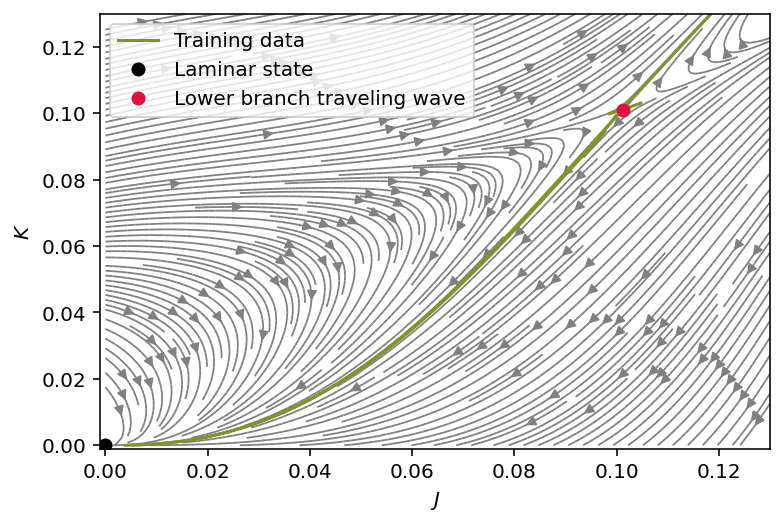

In [46]:
plt.figure()
x_linear = np.linspace(0.0,  0.13, 150)
y_linear = np.linspace(0.0, 0.13, 150)

X, Y = np.meshgrid(x_linear, y_linear)
points_to_eval = np.vstack((X.ravel(), Y.ravel()))

U = ssm.reduced_dynamics.predict(points_to_eval.T) # call the reduced vector field on the grid of points


UU = U[:,0].reshape(X.shape)
VV = U[:,1].reshape(Y.shape)
plt.streamplot(X, Y, UU, VV, density = 3, linewidth = 0.9, color='grey')



# draw the training trajectories:
flag = True
for x in ssm.emb_data['reduced_coordinates']:
    if flag:
        plt.plot(x[0,:], x[1,:], '-', c=linecolor, label = 'Training data')
    else:
        plt.plot(x[0,:], x[1,:], '-', c=linecolor)
    flag = False
    
plt.xlabel('$J$')
plt.ylabel('$K$')
plt.xlim(-0.001,  0.13)
plt.ylim(-0.001, 0.13)
plt.plot(0,0, 'o', c='black', label = 'Laminar state')
plt.plot(*lb_jk_coords, 'o', c='crimson', label = 'Lower branch traveling wave')

plt.legend()


## Computing the stable manifold of the lower branch traveling wave

To find the stable manifold of the lower branch traveling wave, we rely on information about its spectrum, as computed from the SSM-reduced model. 

In [58]:
import sympy as sy
from sympy import latex
from IPython.display import display_latex


# Helper function to print the computed eigenvalue
def disp(idx, symObj):
    eqn = '$$' + idx + ' ' + latex(symObj) + '$$'
    display_latex(eqn,raw=True)
    return

from scipy.optimize import root

In [50]:


predictor = lambda x: ssm.reduced_dynamics.predict(x)
def tocallfunDynamics(t, x, dyn):
    
    dy = dyn(np.array(x).reshape(1,-1))
    return np.squeeze(np.array(dy))
def fixedPt(x, dyn):
    xx = np.array(x)
    odefun = lambda t, x : tocallfunDynamics(t, x, dyn)
    return odefun(0, xx)

We have constrained the SSM-reduced order model to have a fixed point at the $J-K$ coordinates of the lower branch traveling wave. The following calculation verifies that this constraint is satisfied. We use ```scipy```'s built-in root finder method to find the fixed point.

In [51]:
res = root(fixedPt, [0.101185, 0.101185], method = 'lm', tol = 1e-8, args = (predictor))


Given the precise location of the lower branch traveling wave in the SSM-reduced model, we can compute its spectrum, since the stable manifold can be well approximated by integrating a small vector tangent to the stable subspace of the Jacobian.

In [53]:
def computeSpectrum(fixedPoint, delta, dyn):
    # explicit finite difference approximation for the Jacobian
    xpdx = fixedPoint + np.array([delta, 0])
    xmdx = fixedPoint - np.array([delta, 0])
    xpdy = fixedPoint + np.array([0, delta])
    xmdy = fixedPoint - np.array([0, delta])

    fxpdx = dyn(xpdx)[0]
    fxmdx = dyn(xmdx)[0]

    fxpdy = dyn(xpdy)[0]
    fxmdy = dyn(xmdy)[0]


    dfxdx = (fxpdx[0] - fxmdx[0])/(2*delta)
    dfxdx = (fxpdx[0] - fxmdx[0])/(2*delta)

    dfxdy = (fxpdy[0] - fxmdy[0])/(2*delta)
    dfxdy = (fxpdy[0] - fxmdy[0])/(2*delta)

    dfydx = (fxpdx[1] - fxmdx[1])/(2*delta)
    dfydx = (fxpdx[1] - fxmdx[1])/(2*delta)


    dfydy = (fxpdy[1] - fxmdy[1])/(2*delta)
    dfydy = (fxpdy[1] - fxmdy[1])/(2*delta)
    A = np.array([[dfxdx, dfxdy], [dfydx, dfydy]])
    w, v = np.linalg.eig(A)
    return A, w, v

In [54]:
fixedPoint = np.array(res.x).reshape(1,-1)

Df, w, v = computeSpectrum(fixedPoint, 1e-6, predictor)


In [59]:
disp('D\mathbf{f}(J_{LB}, K_{LB})=', sy.Matrix(Df))

This matrix has the eigenvalues and eigenvectors

$$
D\mathbf{f} \mathbf{v}_{\pm} = \lambda_{\pm} \mathbf{v}_{\pm},
$$

with



In [60]:
disp('\mathbf{v}_{-}=', sy.Matrix(v[:,0])) 
disp('\mathbf{v}_{+}=', sy.Matrix(v[:,1]))
disp('\lambda_{-}=', w[0])
disp('\lambda_{+}=', w[1])


To approximate of its stable manifold, we integrate a small segment of the stable subspace in backward time, i.e. the segment defined by the two vectors

$$
\begin{pmatrix}
    J_{LB} \\ K_{LB} 
\end{pmatrix} \pm \varepsilon \mathbf{v}_{-},
$$
with $\varepsilon\approx 10^{-6}$.

In [68]:
ic = res.x + 1e-6*v[:,0]

ic2 = res.x - 1e-6*v[:,0]
teval = np.linspace(0, -1200, 5000)

In [69]:
solStab1 = solve_ivp(tocallfunDynamics, [0, -1200], ic, method = 'DOP853', t_eval = teval, rtol = 1e-12, atol = 1e-12, args=(predictor, ))
solStab2 = solve_ivp(tocallfunDynamics, [0, -1200], ic2, method = 'DOP853', t_eval = teval, rtol = 1e-12, atol = 1e-12, args=(predictor, ))



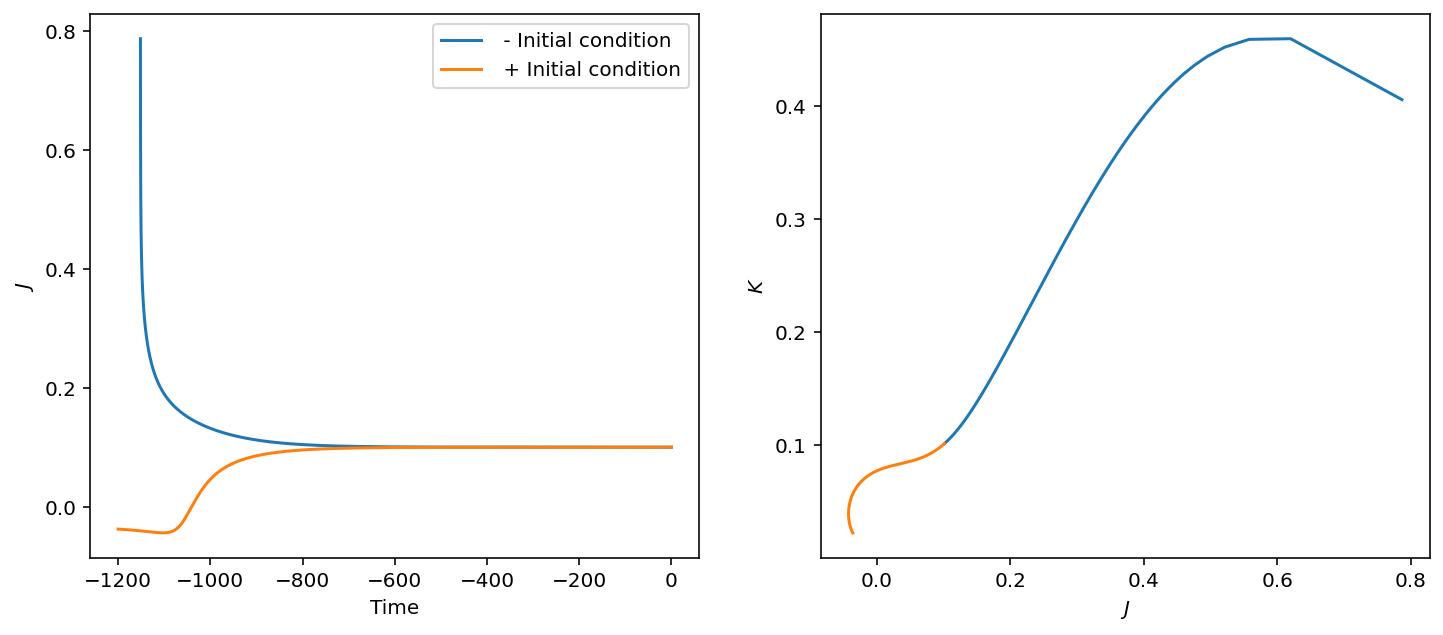

In [70]:
f = plt.figure(figsize = (12,5))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax.plot(solStab2.t, solStab2.y[0,:], label = ' - Initial condition')
ax.plot(solStab1.t, solStab1.y[0,:], label = ' + Initial condition')
ax.set_xlabel('Time')
ax.set_ylabel('$J$')

ax2.plot(solStab2.y[0,:], solStab2.y[1,:], label = ' - Initial condition')
ax2.plot(solStab1.y[0,:], solStab1.y[1,:], label = ' + Initial condition')
ax2.set_xlabel('$J$')
ax2.set_ylabel('$K$')
ax.legend()


In [71]:
linecolor = [0.5111196874841155, 0.573802174897223, 0.1737010491405684]


In [82]:
## The predicted stable manifold quickly runs out of the domain of the training data
# we specify an index along the integrated trajectories, up to which we should display the manifold
index_high_confidence = 3500
index_lower_confidence = 4000

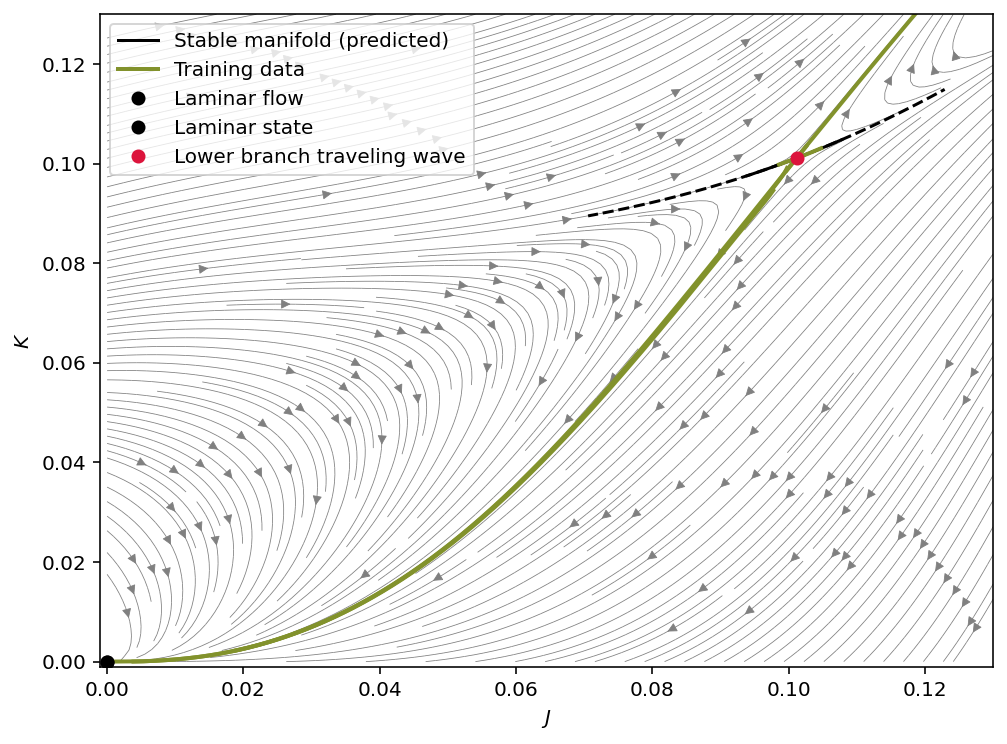

In [83]:
plt.figure(figsize = (8,6))
plt.streamplot(X, Y, UU, VV, density = 3, linewidth = 0.4, color='grey')
plt.plot((solStab1.y[0,:index_lower_confidence]), 
         (solStab1.y[1,:index_lower_confidence]), '--', linewidth = 1.5, c='black')
plt.plot((solStab2.y[0,:4000]),
         (solStab2.y[1,:index_lower_confidence]), '--',  linewidth = 1.5, c='black')


plt.plot((solStab1.y[0,:index_high_confidence]),
         (solStab1.y[1,:index_high_confidence]),
         '-', linewidth = 1.5, c='black', label ='Stable manifold (predicted)')
plt.plot((solStab2.y[0,:index_high_confidence]),
         (solStab2.y[1,:index_high_confidence]),
         '-',  linewidth = 1.5, c='black')


plt.xlabel('$J$')
plt.ylabel('$K$')
flag = True
for x in ssm.emb_data['reduced_coordinates']:
    
    if flag:
        xx = np.hstack((x, np.array([0,0]).reshape(-1,1)))

        plt.plot(xx[0,:], xx[1,:], '-', c=linecolor, linewidth = 2, label= 'Training data')
    else:
        plt.plot(x[0,:], x[1,:], '-', c=linecolor, linewidth = 2)
    flag = False


plt.plot(0,0, 'o', c='black', label = 'Laminar flow')


plt.xlabel('$J$')
plt.ylabel('$K$')
plt.xlim(-0.001,  0.13)
plt.ylim(-0.001, 0.13)
plt.plot(*lb_jk_coords, 'o', c='crimson', label = 'Lower branch traveling wave')

plt.legend(loc = 'upper left')




We may then save the SSM-reduced model for later use:

In [85]:
from joblib import load, dump
!mkdir saved_models

In [86]:
dump(ssm, 'saved_models/ssm_model.model')

['saved_models/ssm_model.model']